In [1]:
import os
import datetime
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Normalizer
import plotnine as p9
import quandl
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

In [2]:
ratio = pd.read_pickle('ratio.pkl')
factor = pd.read_pickle('factor.pkl').shift(1)
# r2 = pd.read_pickle('ic_spearman_rank.pkl')

# Time series prediction of factor return

In this approach, the prediction of factor returns for a given date $i$ is based on a time-weighted moving average of the previous $n$ days' returns. Mathematically, this can be represented as:

$${Predicted Return}_i = \frac{\sum_{j=1}^{n-1} j \times \text{Return}_{i-j}}{\sum_{j=1}^{n-1} j}$$

where $n = 12$, and the weights $w_j$ are assigned linearly such that $w_j = j$ for $j = 1, 2, \ldots, n-1$. This weighting scheme gives more importance to recent returns, with the assumption that they are more indicative of the future return. The sum of the weights is normalized to ensure that the weighted average is properly scaled.

By using this time-weighted moving average method, the model aims to capture the momentum in factor returns, giving more emphasis to recent trends while still considering a historical window of returns. This approach can be particularly useful in financial markets where recent movements may be more relevant for short-term predictions.

In [43]:
'''method 1:auto regression---behave very badly'''
# n = 12

# def autoregressive_predict(window):
#     if len(window) < n:
#         return None
#     X_train = np.array([window[:-1].shift(i).values for i in range(1, n)]).T
#     y_train = window.values[:-1]
#     X_test = np.array([window.shift(i).values for i in range(1, n)]).T[-1].reshape(1, -1)
    
#     model = LinearRegression()
#     model.fit(np.nan_to_num(X_train), np.nan_to_num(y_train))

#     return model.predict(X_test)[0]

# predicted_df = factor.fillna(method='ffill').rolling(window=n).apply(autoregressive_predict, raw=False)


'''method 2:time weighted moving average'''
n = 12

def weighted_average(window):
    if len(window) < n - 1:
        return np.nan
    weights = np.arange(1, n) / np.arange(1, n).sum()
    return (window.iloc[-n + 1:] * weights).sum() / weights.sum()

predicted_factor_ret = factor.rolling(window=n, min_periods=n-1).apply(weighted_average)

**Future improvements in time series forcasting**

We can apply other models to predict the factor return


1. **ARIMA (Autoregressive Integrated Moving Average):** This model extends the moving average approach by incorporating autoregression and differencing to handle non-stationarity. It can capture complex patterns in the data and is widely used for time series forecasting.

2. **LSTM (Long Short-Term Memory):** This type of recurrent neural network is well-suited for modeling time series data due to its ability to capture long-term dependencies. LSTMs have shown promising results in various forecasting tasks.

3. **GARCH (Generalized Autoregressive Conditional Heteroskedasticity):** This model is commonly used for modeling financial time series with volatility clustering, such as stock returns.

# Factor selection

## 1. calculate IC value with Spearman's correlation coefficient

The Information Coefficient (IC) is a measure used to evaluate the predictive power of a given factor or signal on future returns. In this strategy, we use the Spearman rank correlation coefficient to calculate the IC. Here are the reasons:

- Non-Parametric Nature: Unlike Pearson's correlation coefficient, which measures linear relationships between two continuous variables and assumes a normal distribution of the variables, Spearman's correlation is non-parametric. It does not require the variables to be normally distributed. In this case, the Spearman rank correlation is more useful since the equity returns doesn't follow a normal distribution, and relationships between variables might not be linear.

- Rank-Based Method: Spearman's correlation assesses how well the relationship between two variables can be described using a monotonic function. It ranks the data points from each variable separately before calculating the correlation. Our goal is to select the factors based on their ranking, and Spearman's correlation is effective in identifying the predictive power of factors because it is more concerned with the order of values rather than the specific values themselves. 

- Robustness to Outliers: Since Spearman's correlation is based on ranks rather than actual values, it is less sensitive to outliers than Pearson's correlation. In the context of equity trading, where outliers can significantly impact the performance of a trading strategy, this robustness makes Spearman's correlation a preferred choice for calculating the IC score.

- Focus on Directional Accuracy: The use of Spearman's correlation for IC scores emphasizes the importance of directional accuracy over magnitude. In quantitative trading, it is often more valuable to correctly predict the direction of price movements (up or down) rather than the exact magnitude of those movements. Spearman's correlation, by focusing on ranks, aligns well with this objective.

Here's how we can calculate the IC score:
- Rank the Variables: For each month, rank both the predictive factors and the actual outcomes (future returns) from lowest to highest. Each set of variables—predictive factors and outcomes—is ranked separately.

- Calculate the Difference in Ranks (d): For each pair (predictive factor and outcome), calculate the difference in their ranks. This is done by subtracting the rank of the outcome from the rank of the predictive factor for each observation.

- Apply the Spearman Rank Correlation Formula: The Spearman rank correlation coefficient (ρ), which is used as the IC score, is calculated using the following formula:
$$
\rho = 1 - \frac{6 \sum d^2}{n(n^2 - 1)}
$$

We utilize the **scipy.stats** to calculate the Spearman's correlation coefficient. If the correlation p-value is bigger than 0.1, we mark this correlation to be insignificant and change it to 0.0.

In [44]:
### calculate IC ###
ratio.sort_index(level=['date'],ascending=True,inplace=True)
total_date = list(ratio.index.get_level_values('date').unique())
ic_spearman = pd.DataFrame(columns=total_date)
def spearman_corr(x,ic_spearman):
    date = x.index[0][0]
    sp_corr = []
    for i in factor.columns:
        clean = x[[i,'forward_ret']].dropna()
        sp_stats = stats.spearmanr(clean[i],clean['forward_ret'])
        if sp_stats[1]<0.1: #check p-value
            sp_corr.append(sp_stats[0])
        else:
            sp_corr.append(0)
    ic_spearman[date] = sp_corr

ratio.groupby(level=['date']).apply(spearman_corr,ic_spearman)
ic_spearman.index = factor.columns

## 2. rank IC value

For each month, based on the IC values from the last section, we rank the factors, where the factor with the highest IC score has the largest rank. 

In [45]:
### rank by IC###
ic_spearman_rank = abs(ic_spearman.copy())
for i in ic_spearman_rank.columns:
    ic_spearman_rank[i] = ic_spearman_rank[i].rank()
r2 = ic_spearman_rank.copy()

## 3. select factors acording to rank of IC and rank of  factor return

For each month, rank the predicted factor return and IC value. 

Let $r1$ be the rank dataframe of factor return, $r2$ be the rank dataframe of IC value

We denote the performance of the factor with the most simple approach: average of the two rank

$r = \frac{1}{2}(r1 + r2)$

Choose the top 10 factors with largest $r$

In [46]:
### rank by predicted factor return ###
r1 = predicted_factor_ret.T.copy()
for i in r1.columns:
    r1[i] = r1[i].rank()
    
r = (r1 + r2)/2
r = r.dropna(axis=1)
r.head(5)

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31
curr_ratio,15.5,12.25,22.50,18.25,19.75,20.5,16.25,22.00,18.00,10.0,...,17.5,23.00,16.75,16.25,19.50,19.0,13.00,16.5,14.25,21.50
free_cash_flow_per_share,20.0,20.50,14.75,12.25,11.75,8.5,16.00,9.75,11.75,8.0,...,16.0,10.75,14.75,23.00,22.50,17.5,20.50,16.5,24.50,26.00
ret_equity,14.0,11.75,11.75,20.50,15.25,17.5,15.25,13.25,16.75,14.0,...,11.0,10.25,12.25,13.50,10.25,8.5,16.00,14.5,19.50,19.50
gross_margin,15.0,20.50,9.25,8.75,17.50,15.0,14.75,15.75,16.25,16.5,...,18.5,24.50,15.75,13.75,10.75,10.5,10.75,9.5,6.25,9.75
ret_asset,8.0,15.00,7.25,18.00,13.75,10.5,10.25,10.25,12.25,9.5,...,8.0,6.75,13.00,14.00,14.50,15.5,21.00,13.0,10.25,10.25


In [47]:
### choose the factor for each month ###
factor_chosen = {}
for date in r.columns:
    factor_chosen[date] = r[date].nlargest(10).index.tolist()

## 4. Chosen Factor Analysis

### 4.1 Factor Frequency
In this section, we count how many times each factor has been selected.

In [48]:
factor_freq = pd.DataFrame(columns=r.index, index=['frequency'])
total_chosen = []
for i in factor_chosen.values():
    total_chosen += i
for i in factor_freq.columns:
    factor_freq.loc['frequency', i] = total_chosen.count(i)
factor_freq = factor_freq.T.sort_values(by='frequency', ascending=False).T
factor_freq

,rs_volatility,curr_ratio,pe,ret_1_6,asset_turn,skew,ret_6_12,gross_margin,ret_invst,day_sale_rcv,...,rcv_turn,free_cash_flow_per_share,tot_debt_tot_equity,volume_shock,free_cash_flow,invty_turn,ret_0_1,oper_cash_flow_per_share,ret_tang_equity,book_val_per_share
frequency,135,130,113,108,100,97,93,92,85,84,...,62,62,54,54,54,53,49,47,29,18


During our 203 trading days, we choose 'rs_volatility', 'curr_ratio', 'pe', 'ret_1_6', and 'asset_turn' most frequently. Every factor has been chosen at least 18 times.

### 4.2 Factor Selection Accuracy
We use the correlation between **factors' rank by each selection method** and **factor's rank by factor real return** as a metric to evaluate the factor selection accuracy.

In [49]:
factor_ret_rank = pd.read_pickle('factor.pkl').shift(-1)
factor_ret_rank = factor_ret_rank[factor_ret_rank.index >= '2007-03-31'].T
for i in factor_ret_rank.columns:
    factor_ret_rank[i] = factor_ret_rank[i].rank()
factor_ret_rank.head(5)

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31
curr_ratio,15.0,27.0,20.0,3.0,22.0,13.0,3.0,26.0,9.0,7.0,...,25.0,11.0,11.0,5.0,4.0,18.0,26.0,14.0,27.0,NaN
free_cash_flow_per_share,21.0,10.0,8.0,9.0,10.0,4.0,19.0,9.0,15.0,14.0,...,19.0,19.0,24.0,24.0,22.0,19.0,15.0,26.0,25.0,NaN
ret_equity,11.0,11.0,25.0,13.0,19.0,15.0,26.0,15.0,14.0,6.0,...,13.0,9.0,18.0,10.0,15.0,23.0,21.0,18.0,21.0,NaN
gross_margin,5.0,12.0,12.0,26.0,24.0,18.0,16.0,6.0,7.0,8.0,...,4.0,7.0,10.0,13.0,17.0,9.0,10.0,19.0,16.0,NaN
ret_asset,25.0,14.0,17.0,7.0,7.0,3.0,20.0,19.0,16.0,22.0,...,10.0,22.0,25.0,25.0,19.0,5.0,13.0,8.0,6.0,NaN


**IC selection**

In [50]:
ic_sel_accuracy = pd.DataFrame(index=factor_ret_rank.columns, columns=['corr'])
for i in ic_sel_accuracy.index:
    ic_sel_accuracy.loc[i,'corr'] = factor_ret_rank[i].corr(r2[i])
ic_sel_accuracy.T

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31
corr,0.16186,-0.447697,-0.327183,-0.06402,0.09675,0.392633,-0.105504,-0.002773,0.040008,0.186812,...,0.163309,-0.1437,-0.161894,0.531908,0.018174,0.157811,0.497369,0.070917,0.037703,NaN


<Axes: xlabel='date'>

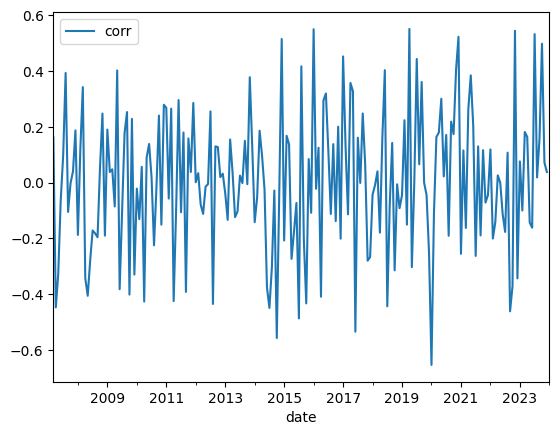

In [51]:
ic_sel_accuracy.plot()

**Predicted Factor Return selection**

In [52]:
pfr_sel_accuracy = pd.DataFrame(index=factor_ret_rank.columns, columns=['corr'])
for i in pfr_sel_accuracy.index:
    pfr_sel_accuracy.loc[i,'corr'] = factor_ret_rank[i].corr(r1[i])
pfr_sel_accuracy.T

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31
corr,-0.349817,0.006716,-0.094642,-0.034799,0.708791,0.602045,0.367272,0.604183,-0.806289,0.24729,...,0.101343,-0.21554,-0.151733,-0.157509,-0.291819,-0.086691,-0.259463,0.5,0.678877,NaN


<Axes: xlabel='date'>

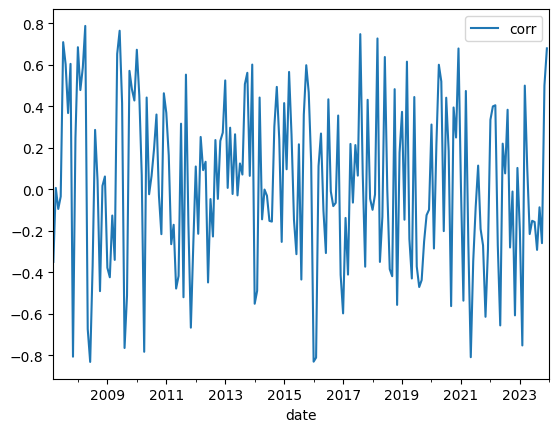

In [53]:
pfr_sel_accuracy.plot()

**IC and Predicted Factor Return combined selection**

In [55]:
combined_sel_accuracy = pd.DataFrame(index=factor_ret_rank.columns, columns=['corr'])
for i in combined_sel_accuracy.index:
    combined_sel_accuracy.loc[i,'corr'] = factor_ret_rank[i].corr(r[i])
combined_sel_accuracy.T

date,2007-03-31,2007-04-30,2007-05-31,2007-06-30,2007-07-31,2007-08-31,2007-09-30,2007-10-31,2007-11-30,2007-12-31,...,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30,2023-10-31,2023-11-30,2023-12-31,2024-01-31
corr,-0.182116,-0.370777,-0.28992,-0.064488,0.660018,0.607242,0.227102,0.556949,-0.66745,0.323694,...,0.172095,-0.215778,-0.200754,0.235304,-0.19104,0.037886,0.180654,0.454982,0.477473,NaN


<Axes: xlabel='date'>

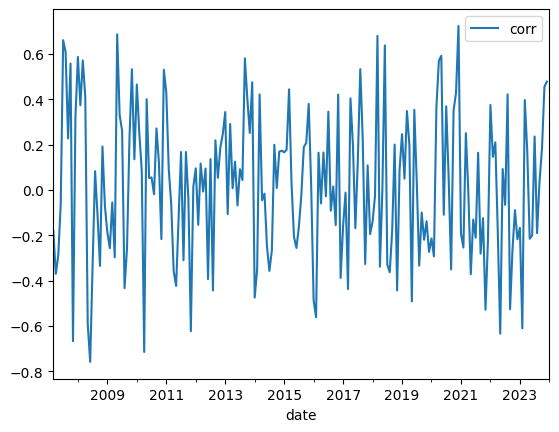

In [56]:
combined_sel_accuracy.plot()

From the factor selection accuracy metric, we conclude that the combined selection method outperforms IC selection or Predicted Factor Return selection method.

## Other methods in choosing factors

1. **Factor Z-Score:** Standardize both factor return and factor IC value by converting them into z-scores. Then, you can combine these z-scores into a single composite score, which can provide a standardized measure of factor performance.

2. **Principal Component Analysis (PCA):** PCA can be used to reduce the dimensionality of the data by combining the two indicators into a single principal component that captures the majority of the variance in the data.

# Use the selected factors to predict stock return

In this approach, we aim to predict the stock returns for each month $i$ using the factor values of the previous month $(i-1)$ as explanatory variables. Specifically, we set $X$ to be the matrix of factor values for all $n$ stocks in month $(i-1)$, and $y$ to be the vector of returns for all $n$ stocks in the same month. We then perform a linear regression to model the relationship between the factor values and the stock returns:

$$y_{i-1} = \alpha_{i-1} + \beta_{i-1} \cdot X_{i-1}$$

where $\alpha_{i-1}$ is the intercept and $\beta_{i-1}$ is the vector of coefficients corresponding to each factor. This regression model is fitted using the data from month $(i-1)$.

Once the model is fitted, we use it to predict the returns for month $i$ by applying the estimated coefficients $\alpha_{i-1}$ and $\beta_{i-1}$ to the factor values of month $i$:

$$y_{i} = \alpha_{i-1} + \beta_{i-1} \cdot X_{i}$$

**Note:**  we normalize the factor data before fitting the regression model. This is done because some factors might have values that are significantly larger than others, which could disproportionately influence the results of the regression. By standardizing the data (subtracting the mean and dividing by the standard deviation), we ensure that each factor contributes more equally to the model, leading to more robust predictions.

$$z = \frac{x - \mu}{\sigma}$$


This method provides a way to leverage the information contained in various factors to forecast future stock returns, assuming that the relationships observed in the past will persist in the future. The use of linear regression allows for a straightforward interpretation of the influence of each factor on the predicted returns.

In [8]:
### get the selected factor value df ###
df = ratio.copy()
df.sort_index(level=['date'],ascending=True,inplace=True)
dates = list(factor_chosen.keys())
df = df.loc[dates[0]:]


ratio_new = pd.DataFrame(index=df.index,columns=list(range(1,11)))
for date in dates:
    factor_list = factor_chosen[date]
    ratio_new.loc[date,:] = df.loc[date,factor_list].values
ratio_new = ratio_new.fillna(0)
ratio_new['ret'] = df['ret_0_1']
ratio_new

1           2       3         4          5  \
date       ticker                                                     
2007-03-31 A        0.9090    0.000000  0.1364  1.907600   0.000000   
           AAL      8.3735    0.000000  5.5227  5.462600   0.000000   
           AAPL    16.1551    0.080789  0.0676  4.389300   0.000000   
           ABT      1.1672    0.063139  2.5537  1.612100   0.292953   
           ADBE     0.0000    0.000000  1.3340  1.669300   0.000000   
...                    ...         ...     ...       ...        ...   
2024-01-31 XYL      0.8547  207.000000  1.7222 -0.161548   1.024250   
           YUM      3.4126  976.000000  1.1336 -0.231484  13.617768   
           ZBH      2.5338  532.100000  2.1105 -0.351048   0.838537   
           ZBRA    -3.7595 -193.000000  1.0576 -1.205703  -0.289058   
           ZTS      2.0069  926.000000  3.8694  0.699079   4.754959   

                               6          7         8          9         10  \
date       ticker                                                             
2007-03-31 A            0.007609   0.389623  0.002937   7.421900   7.421900   
           AAL         -0.157637 -26.162125  0.010265   3.427800   3.427800   
           AAPL        -0.118402   0.000000  0.003795  18.580500  18.580500   
           ABT         -0.117075   0.768733  0.001827  -3.408400  -3.408400   
           ADBE        -0.052091   0.000000  0.004508  23.948700  23.948700   
...                          ...        ...       ...        ...        ...   
2024-01-31 XYL        178.476190   1.233796  1.577200  -0.013515   0.151850   
           YUM         88.691781  -4.877810  4.038500   0.040604   3.650577   
           ZBH        163.116883   1.158954  4.729500   0.136456   0.264265   
           ZBRA    239550.000000  -0.491524 -2.824500   0.108256   0.408658   
           ZTS        145.589147  10.830741  3.155600  -0.048740   0.522764   

                        ret  
date       ticker            
2007-03-31 A      -0.031463  
           AAL     0.138866  
           AAPL   -0.084721  
           ABT    -0.031888  
           ADBE   -0.053073  
...                     ...  
2024-01-31 XYL     0.007539  
           YUM     0.002853  
           ZBH    -0.017254  
           ZBRA    0.093566  
           ZTS     0.032653  

[73146 rows x 11 columns]

In [9]:
### predict stock return ###
predicted_returns = pd.DataFrame(index=ratio_new.index, columns=['predicted_ret'])

for i in range(1, len(dates)):
    ratio_i = ratio_new.loc[dates[i - 1],:].fillna(0)
    ratio_i.iloc[:, :-1] = ratio_i.iloc[:, :-1].apply(lambda x:(x-x.mean())/x.std())
    X_train = ratio_i.iloc[:, :-1].values
    y_train = ratio_i.iloc[:, -1].values
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    X_test = ratio_new.loc[dates[i]].iloc[:, :-1].fillna(0).apply(lambda x:(x-x.mean())/x.std())
    
    y_pred = model.predict(X_test)
    
    predicted_returns.loc[dates[i],'predicted_ret'] = y_pred

In [11]:
predicted_returns.dropna().to_pickle('predicted_return.pkl')

**Other models for generating predicted stock return (Machine Learning models)**

1. **Random Forests:** This ensemble method uses multiple decision trees to make predictions. It is effective in handling non-linear relationships and can provide insights into the importance of different factors.

2. **Gradient Boosting Machines (GBM):** GBM is another ensemble method that builds trees sequentially, with each tree trying to correct the errors of the previous one. It is known for its high accuracy and ability to handle various types of data.

3. **Support Vector Machines (SVM):** SVM can be used for regression tasks (SVR) and is effective in capturing complex relationships in high-dimensional spaces. It works well with both linear and non-linear data.

4. **Neural Networks:** Deep learning models, such as feedforward neural networks or recurrent neural networks (RNNs), can capture intricate patterns in time series data. They are particularly useful for modeling sequential data and can be trained to predict future returns based on past factor values.

5. **Lasso and Ridge Regression:** These are extensions of linear regression that include regularization terms to prevent overfitting and to handle multicollinearity. They can be useful when dealing with a large number of factors.

6. **XGBoost:** An implementation of gradient boosted trees designed for speed and performance, XGBoost is a popular choice for regression tasks and can handle missing data and various types of features.